In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
import seaborn as sns

from struct import unpack

%matplotlib inline

# 读取MNIST数据集

In [2]:
def load_mnist(imagefile, labelfile):
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')
    
     # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)   

In [5]:
train_img, train_lbl = load_mnist('train-images.idx3-ubyte' , 'train-labels.idx1-ubyte')
test_img, test_lbl = load_mnist('t10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte')

# 查看数据大小

In [6]:
print(train_img.shape)
print(train_lbl.shape)
print(test_img.shape)
print(test_lbl.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


# 输出示例图片

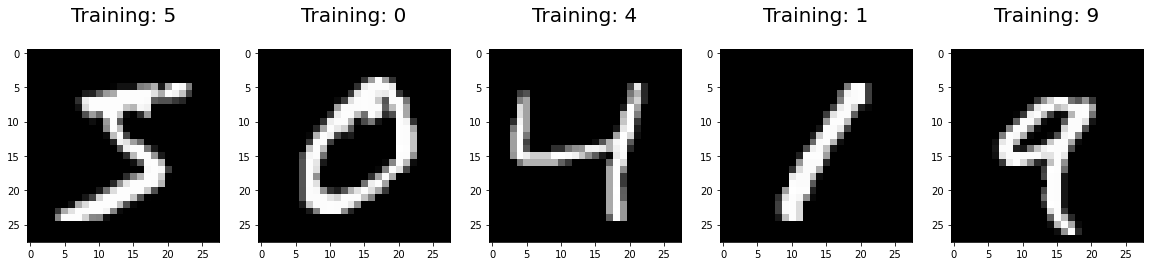

In [8]:
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(train_img[:5], train_lbl[:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
    plt.title(f"Training: {label}\n", fontsize=20)

# Logistic Regression识别0和1 

## 定义sigmoid函数

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## 定义逻辑回归 

In [22]:
class LogisticRegression():
    
    def __init__(self, lamb=1e-4):
        self.weight = None
        self.lamb = lamb
        
    def fit(self, X, y, lr=0.01, tol=1e-5, max_iter=100):
        X = np.c_[np.ones(X.shape[0]), X]
        
        l_prev = np.inf
        self.weight = np.zeros(X.shape[1])
        for _ in range(max_iter):
            y_pred = sigmoid(np.dot(X, self.weight))
            loss = self._NLL(X, y, y_pred)
            
            if l_prev - loss < tol:
                return
            
            l_prev = loss
            self.weight -= lr * self._NLL_grad(X, y, y_pred) 
            
    def _NLL(self, X, y, y_pred):
        nll = -np.log(y_pred[y == 1]).sum() - np.log(y_pred[y == 0]).sum()
        
        weight, lamb = self.weight, self.lamb
        
        norm_weight = np.linalg.norm(weight, ord=2)
        penalty = (lamb / 2) * norm_weight ** 2
        
        return (nll + penalty) / X.shape[0]
    
    def _NLL_grad(self, X, y, y_pred):
        weight, lamb = self.weight, self.lamb
        d_penalty = lamb * weight
        return -(np.dot(y - y_pred, X) + d_penalty) / X.shape[0]
    
    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return (sigmoid(np.dot(X, self.weight)) > 0.5).astype(int)
    
    def compute_acc(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

# 测试结果

[0 1 1 1 1]


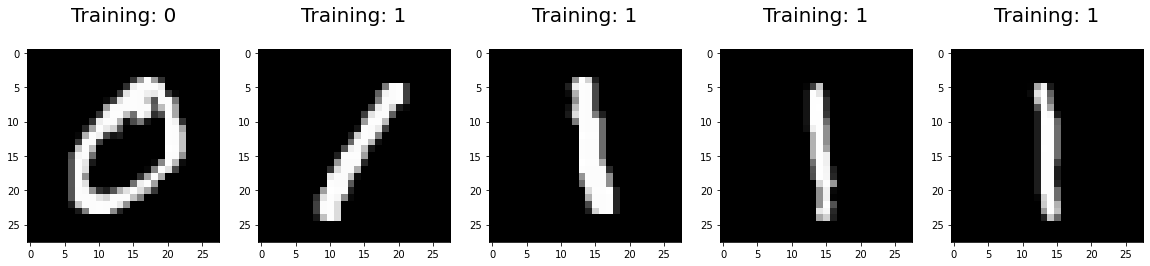

In [14]:
# 分割数据集
train_filter = np.where((train_lbl == 0) | (train_lbl == 1))
test_filter = np.where((test_lbl == 0) | test_lbl == 1)

sub_train_img, sub_train_lbl = train_img[train_filter], train_lbl[train_filter]
sub_test_img, sub_test_lbl = test_img[test_filter], test_lbl[test_filter]

print(sub_train_lbl[:5])
plt.figure(figsize=(20, 4))
for index, (img, lbl) in enumerate(zip(sub_train_img[:5], sub_train_lbl[:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(img, (28, 28)), cmap=plt.cm.gray)
    plt.title("Training: %i\n" % lbl, fontsize=20)

In [23]:
# 训练模型
model = LogisticRegression()
model.fit(sub_train_img, sub_train_lbl)

<ipython-input-10-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
<ipython-input-22-d9e4684c9479>:23: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(y_pred[y == 1]).sum() - np.log(y_pred[y == 0]).sum()


In [31]:
# 准确率
acc = model.compute_acc(sub_test_img, sub_test_lbl)
print(f"Classification Accuracy is: {acc}.")

Classification Accuracy is: 0.9952718676122931.


<ipython-input-10-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Classification Result is: 1.


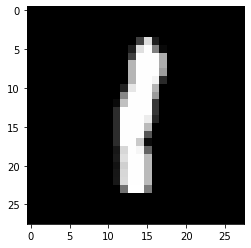

In [36]:
# 可视化图片
visual_image = 11
plt.figure(figsize=(20, 4))
plt.imshow(np.reshape(sub_test_img[visual_image], (28, 28)), cmap=plt.cm.gray)
y = model.predict(sub_test_img[visual_image].reshape(1, -1))
print(f"Classification Result is: {y[0]}.")

<ipython-input-10-b683d5dd8fa4>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


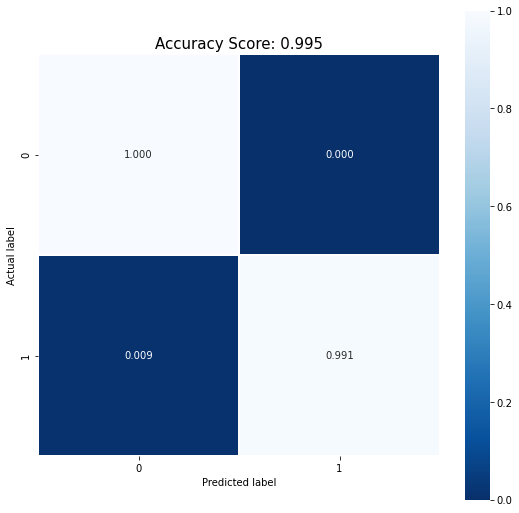

In [33]:
# 错误分析

# 混淆矩阵
predictions = model.predict(sub_test_img)
cm = metrics.confusion_matrix(sub_test_lbl, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9,9))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(acc) 
plt.title(all_sample_title, size = 15);

## 错误分类示例

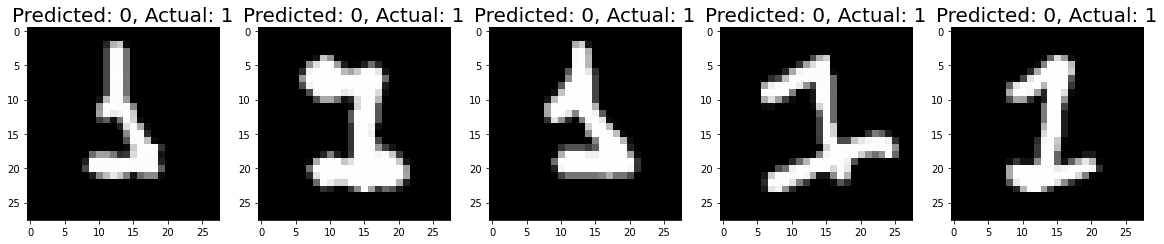

In [35]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(sub_test_lbl, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1

plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[0:5]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(sub_test_img[badIndex], (28,28)), cmap=plt.cm.gray)
#     print(predictions[badIndex])
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], sub_test_lbl[badIndex]), fontsize = 20)

# Softmax Regression 识别 MNIST 

## 定义softmax函数

In [37]:
def softmax(x):
    x_max = np.max(x, axis=-1, keepdims=True)
    exp_x = np.exp(x - x_max)
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

## 定义Softmax Regression

In [86]:
class SoftmaxRegression():
    
    def __init__(self, gamma=1e-4):
        self.weight = None
        self.gamma = gamma
    
    def fit(self, X, y, lr=0.3, max_iter=1000):
        X = np.c_[np.ones(X.shape[0]), X]
        
        # convert labels to one-hot vector
        y = np.eye(10)[y]
            
        self.weight = np.zeros((X.shape[1], 10))
        
        for _ in range(max_iter):
            weight_prev = np.copy(self.weight)
            y_pred = softmax(np.dot(X, self.weight))
            self.weight -= lr * self._NLL_grad(X, y, y_pred)
            if np.allclose(self.weight, weight_prev):
                break
                
    def _NLL_grad(self, X, y, y_pred):
        nll = np.dot(X.T, (y_pred - y))
        d_penalty = self.gamma * self.weight       
        return (nll + d_penalty) / X.shape[0]
    
    def predict(self, X):
        X = np.c_[np.ones(X.shape[0]), X]
        return np.argmax(softmax(np.dot(X, self.weight)), axis=-1)
    
    def compute_acc(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

## 测试模型

In [87]:
smodel = SoftmaxRegression()
# shuffle_index = np.random.permutation(60000)
# shuffle_train_img, shuffle_train_lbl = train_img[shuffle_index], train_lbl[shuffle_index]
smodel.fit(train_img, train_lbl)
acc = smodel.compute_acc(test_img, test_lbl)
print(f"Classification Accuracy is: {acc}.")

Classification Accuracy is: 0.9157.


In [88]:
predictions = smodel.predict(test_img)

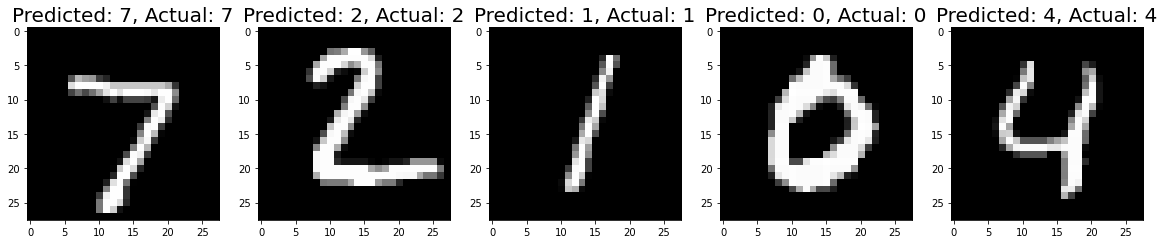

In [89]:
# 展示结果
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(test_img[0:5], test_lbl[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(test_img[index], (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(predictions[index], test_lbl[index]), fontsize = 20)

## confusion matrix

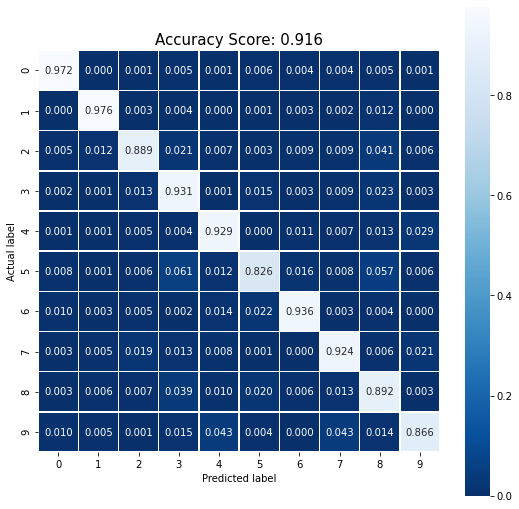

In [90]:
cm = metrics.confusion_matrix(test_lbl, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9,9))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.3f}'.format(acc) 
plt.title(all_sample_title, size = 15);

## 错误分类示例

843


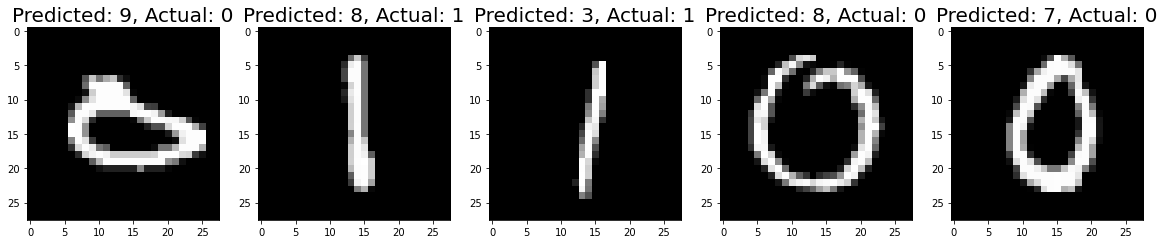

In [91]:
index = 0
misclassifiedIndexes = []
for label, predict in zip(test_lbl, predictions):
    if label != predict: 
        misclassifiedIndexes.append(index)
    index +=1
print(len(misclassifiedIndexes))
plt.figure(figsize=(20,4))
for plotIndex, badIndex in enumerate(misclassifiedIndexes[5:10]):
    plt.subplot(1, 5, plotIndex + 1)
    plt.imshow(np.reshape(sub_test_img[badIndex], (28,28)), cmap=plt.cm.gray)
    plt.title('Predicted: {}, Actual: {}'.format(predictions[badIndex], sub_test_lbl[badIndex]), fontsize = 20)